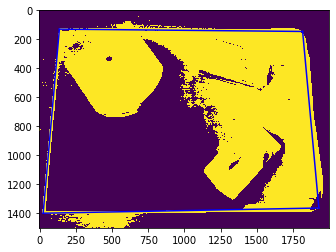

In [1]:
import cv2
import math
import numpy as np
import matplotlib.pyplot as plt

img = cv2.imread('images/track3.jpg', cv2.IMREAD_COLOR)
(b, g, r) = cv2.split(img)
_,threshold = cv2.threshold(b, 80, 255,  
                            cv2.THRESH_BINARY) 

plt.imshow(threshold)

# Detecting shapes in image by selecting region  
# with same colors or intensity.
contours,_=cv2.findContours(threshold, cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE) 

board = None

# Searching through every region selected to  
# find the required polygon.
for cnt in contours : 
    area = cv2.contourArea(cnt) 

    # Shortlisting the regions based on there area. 
    if area > 40000:  
        approx = cv2.approxPolyDP(cnt,  
                                  0.015
                                  * cv2.arcLength(cnt, True), True) 
        if len(approx) == 4:
            board = approx

n= len(board)
for i in range(n):
    vertice1 = board[i][0]
    vertice2 = board[(i+1)%n][0]
    plt.plot((vertice1[0], vertice2[0]), (vertice1[1], vertice2[1]), 'b')
   

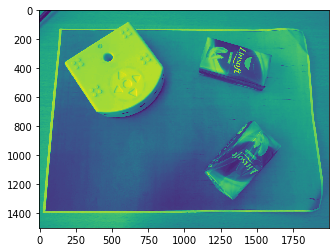

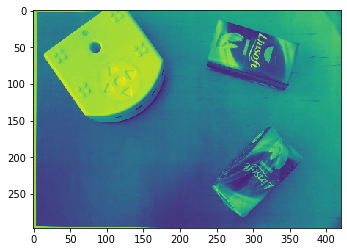

In [2]:
img = cv2.imread('images/track3.jpg', cv2.IMREAD_GRAYSCALE) 
pts0 = np.float32(board)

W, H = 420, 297
# Define corresponding points in output image
pts1 = np.float32([[0,0],[0,H],[W,H],[W,0]])

# Get perspective transform and apply it
M = cv2.getPerspectiveTransform(pts0,pts1)
rescaled_img = cv2.warpPerspective(img,M,(W,H))

# Save reult
plt.imshow(img)
plt.figure()
plt.imshow(rescaled_img)

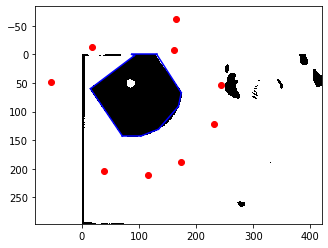

In [3]:
### Image processing filter

filtered_img = cv2.bilateralFilter(rescaled_img,15, 75, 75)
canny_img = cv2.Canny(filtered_img, 100, 200)
plt.imshow(canny_img,cmap='gray')

### Find the thymio and the destination

destination = cv2.imread('images/destination.jpg') 

_,threshold = cv2.threshold(filtered_img, 170, 255,  
                            cv2.THRESH_BINARY) 

plt.imshow(threshold)

# Detecting shapes in image by selecting region  
# with same colors or intensity. 
contours,_=cv2.findContours(threshold, cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE) 

obstacles =  []

# Searching through every region selected to  
# find the required polygon. 
for cnt in contours : 
    area = cv2.contourArea(cnt) 
   
    # Shortlisting the regions based on there area. 
    if area > 4000:  
        approx = cv2.approxPolyDP(cnt,  
                                  0.009 * cv2.arcLength(cnt, True), True) 
        obstacles.append(approx)
        
from numpy import sqrt
def norm(vec):
    return sqrt(vec[0]**2 + vec[1]**2)

MARGIN = 70

way_points = []

plt.imshow(threshold, cmap='Greys')
for obstacle in obstacles:
    n= len(obstacle)
    
    for i in range(n):
        vertice1 = obstacle[i][0]
        vertice2 = obstacle[(i+1)%n][0]
        vertice3 = obstacle[(i+2)%n][0]
        
        vec1 = vertice2 - vertice1
        vec2 = vertice2 - vertice3
        
        normal_vec = vec1/norm(vec1) + vec2/norm(vec2)
        
        way_point = vertice2 + normal_vec*MARGIN/norm(normal_vec)
        way_points.append(way_point)
        
        plt.scatter(way_point[0], way_point[1], c='r')
        plt.plot((vertice1[0], vertice2[0]), (vertice1[1], vertice2[1]), 'b')

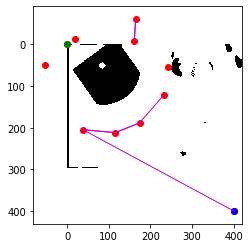

In [4]:
class Node:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.gScore = np.inf
        self.fScore = np.inf
        self.neighbours = []
    def plot(self, color = 'r'):
        plt.scatter(self.x, self.y, c=color)
    def get_pos(self):
        return self.x, self.y
    def __repr__(self):
        return "node ("+str(self.x)+","+str(self.y)+")"
    
def sample_image(threshold, x, y):
    max_y = threshold.shape[0]
    max_x = threshold.shape[1]
    if x >= max_x or x < 0 or y >= max_y or y < 0:
        return 0
    else:
        return threshold[y, x]

def noObstacleBetween(p1, p2):
    x, y = p1
    x_end, y_end = p2
    
    NB_SAMPLE = 80
    NB_SAMPLE_ORTH = 20
    
    for j in range(-NB_SAMPLE_ORTH//2, NB_SAMPLE_ORTH//2):
        l = norm((x_end - x, y_end - y))
        x0 = x - j*(y_end - y)*MARGIN/l/NB_SAMPLE_ORTH*2*0.9
        y0 = y + j*(x_end - x)*MARGIN/l/NB_SAMPLE_ORTH*2*0.9
        for i in range(NB_SAMPLE):
            x_s = x0 + i*(x_end - x)/NB_SAMPLE
            y_s = y0 + i*(y_end - y)/NB_SAMPLE
#             plt.scatter(x_s, y_s, c='g')
            intensity =  sample_image(threshold, int(x_s), int(y_s))
            if intensity == 255:
                return False
    return True

### convert way points to nodes

start = Node(0, 0)
end = Node(400, 400)
graph = [start, end]

for way_point in way_points:
    x, y = way_point
    graph.append(Node(x, y))
    
plt.imshow(threshold, cmap='Greys')
for node in graph:
    node.plot()
start.plot('g')
end.plot('b')
# create lines between nodes, if there is no obstacle inbetween

# noObstacleBetween(start.get_pos(), end.get_pos())
for node in graph:
    for potential_neighbour in graph:
        if potential_neighbour == node:
            continue
        
        x, y = node.get_pos()
        x_end, y_end = potential_neighbour.get_pos()
        
        delta_x = x_end - x
        
        if noObstacleBetween(node.get_pos(), potential_neighbour.get_pos()):
            node.neighbours.append(potential_neighbour)
            plt.plot((x, x_end), (y, y_end), 'm', linewidth=1)

No path found to goal


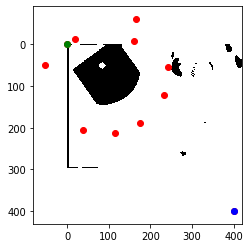

In [5]:
def distance(node1, node2):
    return sqrt((node1.x-node2.x)**2 + (node1.y - node2.y)**2)

### path computation

def A_Star(start, goal, h):
    openSet = [start]
    start.gScore = 0
    closedSet = []
    
    cameFrom = dict()
    
    while openSet != []:
        current = min(openSet, key=lambda node: node.fScore)
        if current == goal:
            path = [current]
            while current in cameFrom.keys():
                path.insert(0, cameFrom[current]) 
                current=cameFrom[current]
            return path
        
        openSet.remove(current)
        closedSet.append(current)
        
        for neighbour in current.neighbours:
            if neighbour in closedSet:
                continue
                
            tentative_gScore = current.gScore + distance(current, neighbour)
            
            if neighbour not in openSet:
                openSet.append(neighbour)
            
            if tentative_gScore < neighbour.gScore:
                cameFrom[neighbour] = current
                neighbour.gScore = tentative_gScore
                neighbour.fScore = neighbour.gScore + h(neighbour)
    print("No path found to goal")
    return None

h = lambda node: distance(node, end)

path = A_Star(start, end, h)


plt.imshow(threshold, cmap='Greys')
for node in graph:
    node.plot()
start.plot('g')
end.plot('b')
    
# draw
if path!=None:
    for i in range(len(path)-1):
        x, y = path[i].get_pos()
        x_end, y_end = path[i+1].get_pos()
        plt.plot((x, x_end), (y, y_end), 'g', linewidth=3)